# Writing KMeans Clustering algorithm for the provided dataset

### The main purpose of the project is to show the difference in performance of algorithm when different centroid initialization strategies are used. For this, we perform the algorithm multiple times with different number of clusters and using two strategies for centroid initialization. 
### Note: No built in libraries like scikit-learn are used for writing the algorithm.

In [1]:
#importing all libraries and loading the data set

import numpy as np # used to manipulate mattrices and calculate mean and standard deviation
import matplotlib.pyplot as plt # used to plot the resultant graphs
import math # used to calculate log
import scipy.io # used to load dataset
import random # used to get random number to initialize centroid

data = scipy.io.loadmat('Datasets/KMeans_Samples.mat') # loading the data set
samples = data['AllSamples'] # extracting samples from the data set

### Euclidean Distance is used as a parameter for training the model

In [2]:
# method to find euclidean distance between two points

def euclideanDistance(x1, y1, x2, y2): 
    return math.sqrt(((x2 - x1) ** 2) + ((y2 - y1) ** 2))

## Strategy 1

### In this strategy all the centroids are initialized by randomly selecting any point from the data samples.

In [3]:
# method to initialize centroids according to Strategy 1

# randomly picking centroids from given samples using 'random' library

def initializeCentroids_Strategy1(samples, k):
    centroids = np.zeros((0,2))
    for i in range(k):
        index = int(random.random() * (samples.shape[0]-1))
        if(samples[index].reshape(1,2) not in centroids):
            centroids = np.append(centroids, samples[index].reshape(1,2), axis = 0)
        else:
            i -= 1
    return centroids

## Strategy 2

### In this strategy, first centroid is selected randomly from the data samples. 
### All the other k-1 centroids (where 'k' is the number of centroids) are chosen such that the average distance of this centroid to all the previous ones is maximal.

In [4]:
# method to initialize centroids according to Strategy 2

# choosing first centroid randomly from the given samples 
# Then choosing a sample such that the average distance of this one to all the previous centroids is maximal

def initializeCentroids_Strategy2(samples, k):
    centroids = np.zeros((0,2))
    
    # choosing first centroid randomly 
    index = int(random.random() * (samples.shape[0]-1))
    centroids = np.append(centroids, samples[index].reshape(1,2), axis = 0)
    
    # finding other centroids with max average distance from others
    for cluster in range(k-1):
        minDistanceList = []

        # finding minimum distance of all the points in the samples from all previous centroids
        # and storing them in 'minDistanceList' (ps. index is same as samples)
        for i in range(samples.shape[0]):
            minDist = 1000
        
            for j in range(centroids.shape[0]):
                d = euclideanDistance(samples[i][0], samples[i][1], centroids[j][0], centroids[j][1])
                minDist = min(d, minDist)
            minDistanceList.append(minDist)

        # the point with largest minimum distance is the point which is farthest from all the previous centroids
        # Therefore, that point is our next centroid.
        
        # as index of 'minDistanceList' and 'samples' is same we find the index of largest distance in 'minDistanceList'
        # using 'np.argmax' and use that index to find point which will be our next centroid
        minDistanceList = np.array(minDistanceList)
        nextCentroid = samples[np.argmax(minDistanceList)].reshape(1,2) 
        centroids = np.append(centroids, nextCentroid, axis = 0)
    return centroids

In [5]:
# method to find the centroid closest to the given sample or point

# for this the method 'euclideanDistance' is used. 
# distance of sample from all the centroids is calculated and the centroid which is the closest is returned

def closestCentroid(sample, centroids):
    index = 0
    minDist = 1000
    for i in range(centroids.shape[0]):
        if(euclideanDistance(sample[0], sample[1], centroids[i][0], centroids[i][1]) < minDist):
            minDist = euclideanDistance(sample[0], sample[1], centroids[i][0], centroids[i][1])
            index = i
    return index

In [6]:
# method to assign samples to their respective nearest centroids
# labels used here are nothing else but the centroid number (or the index of centroid in centroids array)

# using the method 'closestCentroid' closest centroid of the sample is found 
# and the index of centroid in centroids array is used as label to identify the cluster of a sample 

def assignSamplesToCentroids(samples, centroids):
    newSamples = np.zeros((0,3))
    for sample in samples:
        label = closestCentroid(sample, centroids)
        newSamples = np.append(newSamples, [[sample[0], sample[1], label]], axis = 0)
    return newSamples

In [7]:
# method to find new centroids for each and every cluster by taking the mean of all the samples 
# which belong to that particular cluster

# after all the samples are assigned to a cluster, new centroids are calculated
# by finding the average or mean of all the points present in the cluster

def getNewCentroids(labelledSamples, centroids):
    newCentroids = np.zeros((0,2))
    x, y, labels = np.hsplit(labelledSamples, 3)
    for i in range(centroids.shape[0]):
        iLabelIndexes = np.where(labels == i) # indexes of samples which belong to cluster i is found 
        iLabelX = x[iLabelIndexes] # using the indexes points which label i are found
        iLabelY = y[iLabelIndexes]
        
        # average of points is calculated and result is added as new centroid
        newCentroids = np.append(newCentroids, [[np.average(iLabelX), np.average(iLabelY)]], axis = 0) 
    return newCentroids

### KMeans Algorithm

In [8]:
# method to implement KMeans algorithm using the methods defined above

# it uses methods 'assignSamplesToCentroids' and 'getNewCentroids' to run the kmeans algorithm
# first samples are assigned to clusters 
# then new centroids are calculated for every cluster
# then again samples are assigned according to new centroids
# This is repeated unless centroids stop changing.

def KMeansAlgorithm(samples, centroids):
    newCentroids = np.zeros((0, centroids.shape[0]))
    maxIterations = 20 # the maximum number of times the algorithm can run (usually it converges within 10 iterations)

    while(maxIterations != 0):
        maxIterations -= 1
        newSamples = assignSamplesToCentroids(samples, centroids)
        newCentroids = getNewCentroids(newSamples, centroids)
        if(np.array_equal(newCentroids, centroids) or maxIterations == 0):
            return newCentroids
        else:
            centroids = newCentroids

### Objective Function used to analyze the performance of algorithm with different strategies.

In [9]:
# method to calculate the objective function value

# samples or points of a particular cluster are found
# then sum of distance of all those points from the cluster's centroid is calculated
# this is done for all the clusters and sum of all the distances is returned

def objectiveFunction(labelledSamples, centroids):
    squaredError = 0
    for i in range(centroids.shape[0]):
        centroid = centroids[i].reshape(1,2)
        sampleIndexes = np.where(labelledSamples[:, 2] == i) # indexes of samples which belong to cluster i is found
        samples = labelledSamples[sampleIndexes] # using the indexes points which label i are found

        # sum of distance between samples and their respective centroid is calculated
        for sample in samples:
            sample = sample[:2].reshape(1,2)
            squaredError += np.sum((sample - centroid) ** 2)
    return squaredError

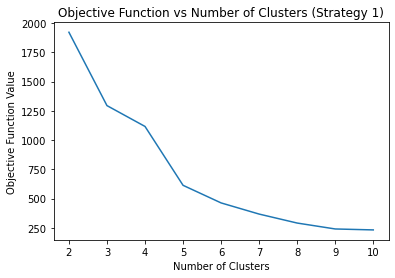

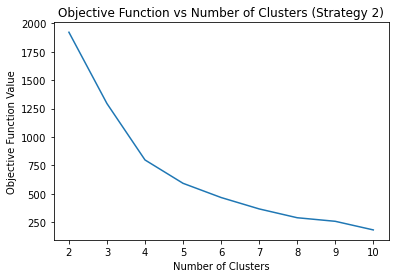

In [10]:
# main
# this cell performs the whole project and prints the required plots

# first initial centroids are found using 'initializeCentroids_Strategy1' and 'initializeCentroids_Strategy2' (2 cases each)
# then using method 'KMeansAlgorithm' final centroids are found
# using the new centroids labels are given to the samples
# using new centroids and new samples, objective function value is found
# this is repeated done for k = 2-10

clusters = np.arange(2, 11)
squaredErrorArray = np.zeros(0)

for k in clusters:
    centroids = initializeCentroids_Strategy1(samples, k)
    newCentroids = KMeansAlgorithm(samples, centroids)
    newSamples = assignSamplesToCentroids(samples, newCentroids)
    squaredError = objectiveFunction(newSamples, newCentroids)
    squaredErrorArray = np.append(squaredErrorArray, squaredError)

plt.plot(clusters, squaredErrorArray)
plt.title("Objective Function vs Number of Clusters (Strategy 1)")
plt.xlabel("Number of Clusters")
plt.ylabel("Objective Function Value")
plt.show()
    
clusters = np.arange(2, 11)
squaredErrorArray = np.zeros(0)

for k in clusters:
    centroids = initializeCentroids_Strategy2(samples, k)
    newCentroids = KMeansAlgorithm(samples, centroids)
    newSamples = assignSamplesToCentroids(samples, newCentroids)
    squaredError = objectiveFunction(newSamples, newCentroids)
    squaredErrorArray = np.append(squaredErrorArray, squaredError)

plt.plot(clusters, squaredErrorArray)
plt.title("Objective Function vs Number of Clusters (Strategy 2)")
plt.xlabel("Number of Clusters")
plt.ylabel("Objective Function Value")
plt.show()